In [1]:
import glob
import os
import csv
import numpy as np
from scipy.signal import medfilt
from scipy.signal import wiener
from scipy.signal import savgol_filter

genders = ['male', 'female']
labels = ['Happy', 'Surprise', 'Disgust', 'Angry', 'Fear', 'Sad', 'Neutral'] # 0-6, 7 classes

def preprocess_data(dataPath, train):
    if train:
        path = os.path.join(dataPath, 'train')
        output_dir = os.path.join(dataPath, 'train.csv')
    else:
        path = os.path.join(dataPath, 'val')
        output_dir = os.path.join(dataPath, 'val.csv')
    folders = glob.glob(os.path.join(path, '*'))
    folders.sort()

    with open(output_dir, 'a+') as csv_output_file:
        fieldnames = ['User', 'Person_min', 'Max', 'Min', 'Mean', 'Var', 'Mean Abs Diff', 'Mean Abs Second Diff', 'Emotion', 'Gender', 'Age'] # The features extracted
        writer = csv.DictWriter(csv_output_file, fieldnames=fieldnames)
        writer.writeheader()

        for dir in folders:
            with open(os.path.join(dir, 'EDA.csv')) as csv_file:
                csv_reader = csv.reader(csv_file)
                line_count = 0
                data = [] # all data for one person
                time_stamp = [] # time stamp for each item

                for row in csv_reader:
                    if line_count == 0:
                        start_time = float(row[0])
                    elif line_count == 1:
                        freq = float(row[0])
                    elif line_count>2 :
                        data.append(float(row[0]))
                        time_stamp.append(start_time + float((line_count-2)/freq))
                    line_count += 1

                #person_Max = max(data)
                #person_Min = min(data)
                data = (data - np.average(data)) / (np.std(data)) # standartization filter
                #data = (np.array(data) - float(person_Min)) / (float(person_Max) - float(person_Min)) # normalised data for each person
                #data = medfilt(data, 11) # median filter; can be substituted by your preprocessing methods
                #data = wiener(data)
                #data = savgol_filter(data, 11, 5)
                person_Max = max(data)
                person_Min = min(data)
                
            
                log = open(os.path.join(dir, 'log.txt'), 'r')
                log_count = 0
                for line in log:
                    if log_count == 0:
                        user = line.split(';')[0].split(':')[-1]
                        age = line.split(';')[1].split(':')[-1]
                        gender = line.split(';')[2].split(':')[-1]
                        gender = genders.index(gender.lower())
                        log_count += 1
                    elif log_count == 1:
                        log_count += 1
                    else:
                        st = float(line.split(';')[1]) # start time of each video
                        et = float(line.split(';')[3]) # end time of each video
                        video_name = line.split(';')[2]
                        if "_" in video_name:
                            emotion_label = line.split(';')[2].split('.')[0][:-10] # emotion label of each video
                        else:
                            emotion_label = line.split(';')[2].split('.')[0][:-9]  # emotion label of each video
                        emotion_label = labels.index(emotion_label)

                        index = np.where(np.logical_and((np.array(time_stamp) >= st), (np.array(time_stamp) <= et)))
                        data_list = data[index[0]]
                        if len(data_list)== 0:
                            break
                        diff_list = [data_list[k+1]-data_list[k] for k in range(len(data_list)-1)]
                        abs_diff_list = abs(np.array(diff_list))
                        second_diff_list = [diff_list[k + 1] - diff_list[k] for k in range(len(diff_list) - 1)]
                        abs_second_diff_list = abs(np.array(second_diff_list))
                        writer.writerow({'User': user, 'Person_min': person_Min,  'Max': max(data_list), 'Min': min(data_list), 'Mean': np.mean(data_list), 'Var': np.var(data_list), 'Mean Abs Diff': np.mean(abs_diff_list), 'Mean Abs Second Diff': np.mean(abs_second_diff_list),'Emotion': emotion_label, 'Gender': gender, 'Age': age})
                log.close()
        csv_file.close()
    csv_output_file.close()

In [2]:
# Preprocessing and reading dat
import pandas as pd
from sklearn.utils import shuffle


os.remove('train.csv')
preprocess_data('', train=1)
os.remove('val.csv')
preprocess_data('', train=0)


Data_train = pd.read_csv("train.csv", sep = ",")
#Data_train = shuffle(Data_train)
#Data_train[Data_train.User == "Person_25"].head(10)
#Data_train.head(20)

Data_val = pd.read_csv("val.csv")
#Data_val = shuffle(Data_val)
#Data_val[Data_val.User == "Person_25"].head(10)

# Vizualisation

In [3]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns


# plt.figure(figsize=(16, 10))
# plt.plot(np.arange(0, 1000, 1), Data_train.Mean.iloc[:1000], scaley = 100)
# plt.title("Mean variations")
# plt.legend(["y = mean common variation"])

# plt.show()

In [4]:
# #Max	Min	Mean	Var	Mean Abs Diff	Mean Abs Second Diff	Emotion

# sns.set(rc = {'figure.figsize':(16, 10)})
# sns.set_theme(style="darkgrid")
# sns.scatterplot(data = Data_train, x = "Mean", y = Data_train.index, hue = "Emotion", palette = "tab10", x_bins= 150)
# #sns.lineplot(data = Data_train.iloc[:1500], x = Data_train.Mean.iloc[:1500], y = np.arange(0, 1500, 1), hue = "Emotion", palette = "tab10")

In [5]:
#Data_train.isna().sum()

In [6]:
#Data_train.Emotion.value_counts()

In [7]:
Data_train[Data_train.User == "Person_25"].head(15)

,User,Person_min,Max,Min,Mean,Var,Mean Abs Diff,Mean Abs Second Diff,Emotion,Gender,Age
984,Person_25,-3.161054,-0.225095,-0.980049,-0.831819,0.005871,0.063326,0.114377,2,0,23
985,Person_25,-3.161054,-0.728419,-0.896161,-0.790007,0.001863,0.049470,0.084974,2,0,23
986,Person_25,-3.161054,-0.644532,-0.896161,-0.753136,0.002122,0.054144,0.097866,2,0,23
987,Person_25,-3.161054,-0.644532,-0.938105,-0.729771,0.003119,0.058719,0.107024,2,0,23
988,Person_25,-3.161054,-0.560645,-0.770363,-0.650419,0.002002,0.049434,0.081600,2,0,23
989,Person_25,-3.161054,-0.476757,-0.728419,-0.576271,0.003171,0.054527,0.099295,2,0,23
990,Person_25,-3.161054,-0.434814,-0.644532,-0.519835,0.002138,0.054760,0.097070,2,0,23
991,Person_25,-3.161054,-0.267039,-0.476757,-0.329043,0.003040,0.064822,0.103861,6,0,23
992,Person_25,-3.161054,-0.225095,-0.392870,-0.301751,0.001950,0.049434,0.083887,6,0,23
993,Person_25,-3.161054,-0.225095,-0.392870,-0.283275,0.002120,0.057323,0.101243,6,0,23


In [8]:
Data_val[Data_val.User == "Person_25"].head(15)



,User,Person_min,Max,Min,Mean,Var,Mean Abs Diff,Mean Abs Second Diff,Emotion,Gender,Age
672,Person_25,-3.161054,-0.350926,-0.476757,-0.409106,0.001893,0.055925,0.095458,2,0,23
673,Person_25,-3.161054,-0.308983,-0.476757,-0.384915,0.001969,0.055925,0.089130,2,0,23
674,Person_25,-3.161054,-0.308983,-0.476757,-0.374634,0.001350,0.034318,0.063914,2,0,23
675,Person_25,-3.161054,-0.308983,-0.560645,-0.384804,0.002980,0.058721,0.096121,2,0,23
676,Person_25,-3.161054,-0.267039,-0.434814,-0.349480,0.002364,0.061418,0.100976,2,0,23
677,Person_25,-3.161054,0.823431,0.655689,0.756704,0.001864,0.045935,0.079690,3,0,23
678,Person_25,-3.161054,0.823431,0.697600,0.767506,0.001137,0.039322,0.066298,3,0,23
679,Person_25,-3.161054,0.865375,0.655689,0.754458,0.002514,0.056240,0.105342,3,0,23
680,Person_25,-3.161054,0.865375,0.697600,0.783955,0.001753,0.039322,0.067110,3,0,23
681,Person_25,-3.161054,0.907318,0.697600,0.813444,0.002497,0.060818,0.105963,3,0,23


####  Data is distributed normally. No NaN values. Sad and happy emotions have more samples than others -> might have to equalize value counts

In [9]:
# Merging val and train data
print(Data_train.shape, Data_val.shape)
Data_train = pd.merge(Data_train, Data_val, how = 'outer')
Data_train.shape

(3554, 11)


(5291, 11)

### Modeling

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.regularizers import L1, L2, L1L2

def initModelGRU(shape, outputUnits, outputActivation) -> tf.keras.Model:
    tf.keras.backend.clear_session()
    
    inputs = tf.keras.Input(shape = (shape))
    expand = tf.expand_dims(inputs, axis = 2)
                                                            #dropout better than L reg
    gru1 = tf.keras.layers.GRU(128, return_sequences = True, recurrent_dropout = 0.25, activation = 'relu')(expand) 
    flatten = tf.keras.layers.Flatten()(gru1)  
                                                        #use softmax for prob distribution!
    outputs = tf.keras.layers.Dense(outputUnits, activation = outputActivation)(flatten)    
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    print(model.summary())
    return model

def initModelBasic(shape, outputUnits) -> tf.keras.Model:
    tf.keras.backend.clear_session()
    model = Sequential()
    
    model.add(tf.keras.Input(shape = (shape)))
    
    model.add(Dense(16, activation = 'linear'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(16, activation = 'linear'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(outputUnits, activation = 'softmax'))
    print(model.summary())
    return model

    

In [16]:
from sklearn.model_selection import train_test_split


np.random.seed = 123

y = Data_train.Emotion
X = pd.DataFrame(Data_train.drop(['Emotion','User'], axis = 1))

#y_val = Data_val.Emotion
#X_val = pd.DataFrame(Data_val.drop(['Emotion', 'User'], axis = 1))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)


#Trying adam optimizer
model = initModelGRU(X.shape[1], 7, 'softmax') 

#model = initModelBasic(X.shape[1], 7)
model.compile(
    optimizer= 'adam',
    loss='sparse_categorical_crossentropy', # sparse because using integer labels for emotions (not OHE)
    metrics=[ 'sparse_categorical_accuracy']
)

history = model.fit(
    X_train,
    y_train,
    #validation_split = 0.3,
    #validation_data = (X_val, y_val),
    validation_data = (X_test, y_test),
    epochs=600,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy',
            patience=100,
            restore_best_weights=True
        )
    ]
)

#Result on test data
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy of the model on test set: {:.3f}%".format(model_acc * 100))

#Result on val data
model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Accuracy of the model on validation set: {:.3f}%".format(model_acc * 100))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 9, 1)             0         
                                                                 
 gru (GRU)                   (None, 9, 128)            50304     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 7)                 8071      
                                                                 
Total params: 58,375
Trainable params: 58,375
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/600
105/105 [==============================]

Epoch 40/600
105/105 [==============================] - 2s 17ms/step - loss: 1.8455 - sparse_categorical_accuracy: 0.2404 - val_loss: 1.8647 - val_sparse_categorical_accuracy: 0.2091
Epoch 41/600
105/105 [==============================] - 2s 16ms/step - loss: 1.8448 - sparse_categorical_accuracy: 0.2428 - val_loss: 1.8723 - val_sparse_categorical_accuracy: 0.2173
Epoch 42/600
105/105 [==============================] - 2s 16ms/step - loss: 1.8399 - sparse_categorical_accuracy: 0.2443 - val_loss: 1.8500 - val_sparse_categorical_accuracy: 0.2380
Epoch 43/600
105/105 [==============================] - 2s 16ms/step - loss: 1.8372 - sparse_categorical_accuracy: 0.2323 - val_loss: 1.8616 - val_sparse_categorical_accuracy: 0.2324
Epoch 44/600
105/105 [==============================] - 2s 16ms/step - loss: 1.8430 - sparse_categorical_accuracy: 0.2386 - val_loss: 1.8473 - val_sparse_categorical_accuracy: 0.2462
Epoch 45/600
105/105 [==============================] - 2s 17ms/step - loss: 1.8343 -

Epoch 85/600
105/105 [==============================] - 2s 15ms/step - loss: 1.7506 - sparse_categorical_accuracy: 0.2962 - val_loss: 1.8046 - val_sparse_categorical_accuracy: 0.2645
Epoch 86/600
105/105 [==============================] - 2s 15ms/step - loss: 1.7532 - sparse_categorical_accuracy: 0.2860 - val_loss: 1.8124 - val_sparse_categorical_accuracy: 0.2651
Epoch 87/600
105/105 [==============================] - 2s 15ms/step - loss: 1.7459 - sparse_categorical_accuracy: 0.2950 - val_loss: 1.8144 - val_sparse_categorical_accuracy: 0.2500
Epoch 88/600
105/105 [==============================] - 2s 15ms/step - loss: 1.7447 - sparse_categorical_accuracy: 0.2989 - val_loss: 1.8128 - val_sparse_categorical_accuracy: 0.2607
Epoch 89/600
105/105 [==============================] - 2s 15ms/step - loss: 1.7441 - sparse_categorical_accuracy: 0.3001 - val_loss: 1.8135 - val_sparse_categorical_accuracy: 0.2702
Epoch 90/600
105/105 [==============================] - 2s 15ms/step - loss: 1.7472 -

105/105 [==============================] - 2s 15ms/step - loss: 1.6672 - sparse_categorical_accuracy: 0.3304 - val_loss: 1.7440 - val_sparse_categorical_accuracy: 0.3004
Epoch 130/600
105/105 [==============================] - 2s 15ms/step - loss: 1.6588 - sparse_categorical_accuracy: 0.3385 - val_loss: 1.7416 - val_sparse_categorical_accuracy: 0.2935
Epoch 131/600
105/105 [==============================] - 2s 15ms/step - loss: 1.6683 - sparse_categorical_accuracy: 0.3376 - val_loss: 1.7484 - val_sparse_categorical_accuracy: 0.3123
Epoch 132/600
105/105 [==============================] - 2s 17ms/step - loss: 1.6532 - sparse_categorical_accuracy: 0.3499 - val_loss: 1.7548 - val_sparse_categorical_accuracy: 0.3060
Epoch 133/600
105/105 [==============================] - 2s 16ms/step - loss: 1.6644 - sparse_categorical_accuracy: 0.3301 - val_loss: 1.7391 - val_sparse_categorical_accuracy: 0.3117
Epoch 134/600
105/105 [==============================] - 2s 17ms/step - loss: 1.6550 - sparse_

105/105 [==============================] - 2s 15ms/step - loss: 1.5955 - sparse_categorical_accuracy: 0.3637 - val_loss: 1.7130 - val_sparse_categorical_accuracy: 0.3205
Epoch 174/600
105/105 [==============================] - 2s 15ms/step - loss: 1.5903 - sparse_categorical_accuracy: 0.3715 - val_loss: 1.6993 - val_sparse_categorical_accuracy: 0.3319
Epoch 175/600
105/105 [==============================] - 2s 15ms/step - loss: 1.5993 - sparse_categorical_accuracy: 0.3643 - val_loss: 1.6845 - val_sparse_categorical_accuracy: 0.3319
Epoch 176/600
105/105 [==============================] - 2s 18ms/step - loss: 1.5743 - sparse_categorical_accuracy: 0.3755 - val_loss: 1.6829 - val_sparse_categorical_accuracy: 0.3262
Epoch 177/600
105/105 [==============================] - 2s 15ms/step - loss: 1.6012 - sparse_categorical_accuracy: 0.3592 - val_loss: 1.6842 - val_sparse_categorical_accuracy: 0.3363
Epoch 178/600
105/105 [==============================] - 2s 15ms/step - loss: 1.5908 - sparse_

105/105 [==============================] - 2s 16ms/step - loss: 1.5354 - sparse_categorical_accuracy: 0.3878 - val_loss: 1.6438 - val_sparse_categorical_accuracy: 0.3608
Epoch 218/600
105/105 [==============================] - 2s 15ms/step - loss: 1.5177 - sparse_categorical_accuracy: 0.3989 - val_loss: 1.6466 - val_sparse_categorical_accuracy: 0.3489
Epoch 219/600
105/105 [==============================] - 2s 15ms/step - loss: 1.5365 - sparse_categorical_accuracy: 0.3977 - val_loss: 1.6433 - val_sparse_categorical_accuracy: 0.3520
Epoch 220/600
105/105 [==============================] - 2s 15ms/step - loss: 1.5256 - sparse_categorical_accuracy: 0.4091 - val_loss: 1.6613 - val_sparse_categorical_accuracy: 0.3564
Epoch 221/600
105/105 [==============================] - 2s 15ms/step - loss: 1.5100 - sparse_categorical_accuracy: 0.3998 - val_loss: 1.6392 - val_sparse_categorical_accuracy: 0.3539
Epoch 222/600
105/105 [==============================] - 2s 15ms/step - loss: 1.5198 - sparse_

105/105 [==============================] - 2s 16ms/step - loss: 1.4610 - sparse_categorical_accuracy: 0.4295 - val_loss: 1.5995 - val_sparse_categorical_accuracy: 0.3791
Epoch 262/600
105/105 [==============================] - 2s 15ms/step - loss: 1.4567 - sparse_categorical_accuracy: 0.4241 - val_loss: 1.5964 - val_sparse_categorical_accuracy: 0.3879
Epoch 263/600
105/105 [==============================] - 2s 16ms/step - loss: 1.4600 - sparse_categorical_accuracy: 0.4136 - val_loss: 1.5988 - val_sparse_categorical_accuracy: 0.3879
Epoch 264/600
105/105 [==============================] - 2s 15ms/step - loss: 1.4709 - sparse_categorical_accuracy: 0.4205 - val_loss: 1.6170 - val_sparse_categorical_accuracy: 0.3722
Epoch 265/600
105/105 [==============================] - 2s 15ms/step - loss: 1.4536 - sparse_categorical_accuracy: 0.4226 - val_loss: 1.5967 - val_sparse_categorical_accuracy: 0.3753
Epoch 266/600
105/105 [==============================] - 2s 16ms/step - loss: 1.4551 - sparse_

105/105 [==============================] - 2s 20ms/step - loss: 1.4106 - sparse_categorical_accuracy: 0.4478 - val_loss: 1.5624 - val_sparse_categorical_accuracy: 0.3980
Epoch 306/600
105/105 [==============================] - 2s 23ms/step - loss: 1.4053 - sparse_categorical_accuracy: 0.4523 - val_loss: 1.5445 - val_sparse_categorical_accuracy: 0.3986
Epoch 307/600
105/105 [==============================] - 2s 23ms/step - loss: 1.4059 - sparse_categorical_accuracy: 0.4499 - val_loss: 1.5344 - val_sparse_categorical_accuracy: 0.4118
Epoch 308/600
105/105 [==============================] - 2s 17ms/step - loss: 1.3925 - sparse_categorical_accuracy: 0.4511 - val_loss: 1.5481 - val_sparse_categorical_accuracy: 0.3942
Epoch 309/600
105/105 [==============================] - 2s 21ms/step - loss: 1.4008 - sparse_categorical_accuracy: 0.4322 - val_loss: 1.5542 - val_sparse_categorical_accuracy: 0.4131
Epoch 310/600
105/105 [==============================] - 2s 22ms/step - loss: 1.3938 - sparse_

105/105 [==============================] - 2s 15ms/step - loss: 1.3431 - sparse_categorical_accuracy: 0.4652 - val_loss: 1.5278 - val_sparse_categorical_accuracy: 0.4320
Epoch 350/600
105/105 [==============================] - 2s 15ms/step - loss: 1.3404 - sparse_categorical_accuracy: 0.4673 - val_loss: 1.5261 - val_sparse_categorical_accuracy: 0.4188
Epoch 351/600
105/105 [==============================] - 2s 15ms/step - loss: 1.3442 - sparse_categorical_accuracy: 0.4607 - val_loss: 1.5314 - val_sparse_categorical_accuracy: 0.4175
Epoch 352/600
105/105 [==============================] - 2s 15ms/step - loss: 1.3537 - sparse_categorical_accuracy: 0.4595 - val_loss: 1.5072 - val_sparse_categorical_accuracy: 0.4099
Epoch 353/600
105/105 [==============================] - 2s 15ms/step - loss: 1.3345 - sparse_categorical_accuracy: 0.4682 - val_loss: 1.5148 - val_sparse_categorical_accuracy: 0.4169
Epoch 354/600
105/105 [==============================] - 2s 15ms/step - loss: 1.3416 - sparse_

105/105 [==============================] - 2s 20ms/step - loss: 1.3107 - sparse_categorical_accuracy: 0.4916 - val_loss: 1.4709 - val_sparse_categorical_accuracy: 0.4326
Epoch 394/600
105/105 [==============================] - 2s 19ms/step - loss: 1.3080 - sparse_categorical_accuracy: 0.4874 - val_loss: 1.4755 - val_sparse_categorical_accuracy: 0.4332
Epoch 395/600
105/105 [==============================] - 2s 19ms/step - loss: 1.2947 - sparse_categorical_accuracy: 0.4829 - val_loss: 1.4742 - val_sparse_categorical_accuracy: 0.4288
Epoch 396/600
105/105 [==============================] - 2s 19ms/step - loss: 1.2789 - sparse_categorical_accuracy: 0.4976 - val_loss: 1.4860 - val_sparse_categorical_accuracy: 0.4225
Epoch 397/600
105/105 [==============================] - 2s 21ms/step - loss: 1.3087 - sparse_categorical_accuracy: 0.4925 - val_loss: 1.4753 - val_sparse_categorical_accuracy: 0.4433
Epoch 398/600
105/105 [==============================] - 2s 19ms/step - loss: 1.3041 - sparse_

105/105 [==============================] - 2s 21ms/step - loss: 1.2761 - sparse_categorical_accuracy: 0.4889 - val_loss: 1.4885 - val_sparse_categorical_accuracy: 0.4490
Epoch 438/600
105/105 [==============================] - 2s 19ms/step - loss: 1.2718 - sparse_categorical_accuracy: 0.4838 - val_loss: 1.4657 - val_sparse_categorical_accuracy: 0.4490
Epoch 439/600
105/105 [==============================] - 2s 21ms/step - loss: 1.2450 - sparse_categorical_accuracy: 0.5192 - val_loss: 1.4681 - val_sparse_categorical_accuracy: 0.4465
Epoch 440/600
105/105 [==============================] - 2s 18ms/step - loss: 1.2701 - sparse_categorical_accuracy: 0.4976 - val_loss: 1.4492 - val_sparse_categorical_accuracy: 0.4521
Epoch 441/600
105/105 [==============================] - 2s 18ms/step - loss: 1.2481 - sparse_categorical_accuracy: 0.5012 - val_loss: 1.4633 - val_sparse_categorical_accuracy: 0.4458
Epoch 442/600
105/105 [==============================] - 2s 18ms/step - loss: 1.2671 - sparse_

105/105 [==============================] - 2s 21ms/step - loss: 1.2213 - sparse_categorical_accuracy: 0.5147 - val_loss: 1.4377 - val_sparse_categorical_accuracy: 0.4471
Epoch 482/600
105/105 [==============================] - 2s 20ms/step - loss: 1.2169 - sparse_categorical_accuracy: 0.5186 - val_loss: 1.4444 - val_sparse_categorical_accuracy: 0.4591
Epoch 483/600
105/105 [==============================] - 2s 19ms/step - loss: 1.2239 - sparse_categorical_accuracy: 0.5210 - val_loss: 1.4322 - val_sparse_categorical_accuracy: 0.4635
Epoch 484/600
105/105 [==============================] - 2s 20ms/step - loss: 1.2290 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.4598 - val_sparse_categorical_accuracy: 0.4515
Epoch 485/600
105/105 [==============================] - 2s 19ms/step - loss: 1.2123 - sparse_categorical_accuracy: 0.5141 - val_loss: 1.4151 - val_sparse_categorical_accuracy: 0.4446
Epoch 486/600
105/105 [==============================] - 2s 20ms/step - loss: 1.2271 - sparse_

105/105 [==============================] - 2s 19ms/step - loss: 1.2110 - sparse_categorical_accuracy: 0.5204 - val_loss: 1.4579 - val_sparse_categorical_accuracy: 0.4534
Epoch 526/600
105/105 [==============================] - 2s 18ms/step - loss: 1.2000 - sparse_categorical_accuracy: 0.5177 - val_loss: 1.4253 - val_sparse_categorical_accuracy: 0.4830
Epoch 527/600
105/105 [==============================] - 2s 18ms/step - loss: 1.2028 - sparse_categorical_accuracy: 0.5255 - val_loss: 1.4192 - val_sparse_categorical_accuracy: 0.4685
Epoch 528/600
105/105 [==============================] - 2s 18ms/step - loss: 1.2095 - sparse_categorical_accuracy: 0.5198 - val_loss: 1.4338 - val_sparse_categorical_accuracy: 0.4553
Epoch 529/600
105/105 [==============================] - 2s 18ms/step - loss: 1.1923 - sparse_categorical_accuracy: 0.5219 - val_loss: 1.4280 - val_sparse_categorical_accuracy: 0.4641
Epoch 530/600
105/105 [==============================] - 2s 19ms/step - loss: 1.1975 - sparse_

105/105 [==============================] - 2s 19ms/step - loss: 1.1737 - sparse_categorical_accuracy: 0.5306 - val_loss: 1.4298 - val_sparse_categorical_accuracy: 0.4691
Epoch 570/600
105/105 [==============================] - 2s 20ms/step - loss: 1.1705 - sparse_categorical_accuracy: 0.5324 - val_loss: 1.4086 - val_sparse_categorical_accuracy: 0.4798
Epoch 571/600
105/105 [==============================] - 2s 20ms/step - loss: 1.1563 - sparse_categorical_accuracy: 0.5390 - val_loss: 1.4135 - val_sparse_categorical_accuracy: 0.4647
Epoch 572/600
105/105 [==============================] - 2s 20ms/step - loss: 1.1681 - sparse_categorical_accuracy: 0.5375 - val_loss: 1.4328 - val_sparse_categorical_accuracy: 0.4610
Epoch 573/600
105/105 [==============================] - 2s 21ms/step - loss: 1.1861 - sparse_categorical_accuracy: 0.5315 - val_loss: 1.4557 - val_sparse_categorical_accuracy: 0.4673
Epoch 574/600
105/105 [==============================] - 2s 20ms/step - loss: 1.1665 - sparse_

acc:  0.03511801957397812


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy of the model on test set: 18.408%
Accuracy of the model on validation set: 18.538%


TensorShape([1737])

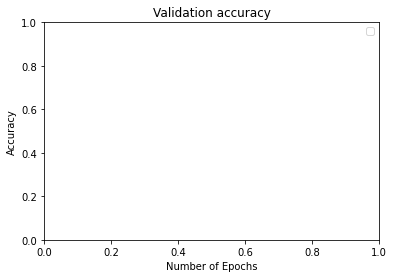

In [88]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#model.save('8_features_train_test_16.983')
#test 60.691  val 16.983
#model = load_model('8_features_train_test') #val 19%!

acc =tf.keras.metrics.sparse_categorical_accuracy(y_val, model.predict(X_val))
acc.numpy()
print("acc: ", accuracy_score(y_val, acc))


model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy of the model on test set: {:.3f}%".format(model_acc * 100))



# Plot the accuracy curve for training
#plt.plot(history.history['val_accuracy'], color='r', label="Accuracy")

plt.title("Validation accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
#plt.show()

model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Accuracy of the model on validation set: {:.3f}%".format(model_acc * 100))

acc.shape

In [84]:
# # Training on validation data (Experimental)
# from sklearn.model_selection import train_test_split


# y_val = Data_val.Emotion
# X_val = pd.DataFrame(Data_val.drop(['Emotion', 'User'], axis = 1))

# X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_val, y_val, test_size = 0.3, random_state = 123)


# #Trying adam optimizer
# modelVal = initModelGRU(X.shape[1], 7, 'softmax')
# modelVal.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# historyVal = modelVal.fit(
#     X_train_val,
#     y_train_val,
#     validation_data = (X_test_val, y_test_val),
#     epochs=1000,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=100,
#             restore_best_weights=True
#         )
#     ]
# )

# #Result of adam optimizer on validation data
# model_acc = modelVal.evaluate(X_test_val, y_test_val, verbose=0)[1]
# print("Validation Accuracy: {:.3f}%".format(model_acc * 100))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 9, 1)             0         
                                                                 
 gru (GRU)                   (None, 9, 256)            198912    
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 7)                 16135     
                                                                 
Total params: 215,047
Trainable params: 215,047
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
38/38 [==============================

Epoch 107/1000
38/38 [==============================] - 1s 35ms/step - loss: 1.2008 - accuracy: 0.5053 - val_loss: 1.3129 - val_accuracy: 0.4866
Epoch 108/1000
38/38 [==============================] - 1s 37ms/step - loss: 1.1968 - accuracy: 0.5251 - val_loss: 1.2973 - val_accuracy: 0.4789
Epoch 109/1000
38/38 [==============================] - 2s 57ms/step - loss: 1.1777 - accuracy: 0.5136 - val_loss: 1.3076 - val_accuracy: 0.5077
Epoch 110/1000
38/38 [==============================] - 3s 90ms/step - loss: 1.1519 - accuracy: 0.5284 - val_loss: 1.3027 - val_accuracy: 0.5077
Epoch 111/1000
38/38 [==============================] - 4s 103ms/step - loss: 1.1545 - accuracy: 0.5333 - val_loss: 1.3478 - val_accuracy: 0.5096
Epoch 112/1000
38/38 [==============================] - 3s 92ms/step - loss: 1.1566 - accuracy: 0.5202 - val_loss: 1.3114 - val_accuracy: 0.4981
Epoch 113/1000
38/38 [==============================] - 3s 84ms/step - loss: 1.1667 - accuracy: 0.5284 - val_loss: 1.2720 - val_a

38/38 [==============================] - 1s 38ms/step - loss: 0.8975 - accuracy: 0.6255 - val_loss: 1.1933 - val_accuracy: 0.6054
Epoch 220/1000
38/38 [==============================] - 2s 47ms/step - loss: 0.8827 - accuracy: 0.6362 - val_loss: 1.2186 - val_accuracy: 0.5747
Epoch 221/1000
38/38 [==============================] - 4s 109ms/step - loss: 0.8770 - accuracy: 0.6370 - val_loss: 1.2194 - val_accuracy: 0.5690
Epoch 222/1000
38/38 [==============================] - 4s 108ms/step - loss: 0.8879 - accuracy: 0.6354 - val_loss: 1.2194 - val_accuracy: 0.5977
Epoch 223/1000
38/38 [==============================] - 5s 119ms/step - loss: 0.8923 - accuracy: 0.6387 - val_loss: 1.2297 - val_accuracy: 0.5728
Epoch 224/1000
38/38 [==============================] - 3s 79ms/step - loss: 0.8979 - accuracy: 0.6272 - val_loss: 1.2010 - val_accuracy: 0.5690
Epoch 225/1000
38/38 [==============================] - 1s 38ms/step - loss: 0.8750 - accuracy: 0.6263 - val_loss: 1.2033 - val_accuracy: 0.59

38/38 [==============================] - 2s 57ms/step - loss: 0.7569 - accuracy: 0.6741 - val_loss: 1.2542 - val_accuracy: 0.6456
Epoch 332/1000
38/38 [==============================] - 1s 34ms/step - loss: 0.7976 - accuracy: 0.6650 - val_loss: 1.2216 - val_accuracy: 0.6245
Epoch 333/1000
38/38 [==============================] - 1s 34ms/step - loss: 0.7627 - accuracy: 0.6642 - val_loss: 1.2549 - val_accuracy: 0.5977
Epoch 334/1000
38/38 [==============================] - 1s 36ms/step - loss: 0.7383 - accuracy: 0.6724 - val_loss: 1.2573 - val_accuracy: 0.6226
Epoch 335/1000
38/38 [==============================] - 1s 36ms/step - loss: 0.7911 - accuracy: 0.6560 - val_loss: 1.3300 - val_accuracy: 0.5728
Epoch 336/1000
38/38 [==============================] - 1s 35ms/step - loss: 0.7552 - accuracy: 0.6683 - val_loss: 1.2894 - val_accuracy: 0.6111
Epoch 337/1000
38/38 [==============================] - 1s 35ms/step - loss: 0.7837 - accuracy: 0.6708 - val_loss: 1.3041 - val_accuracy: 0.5958


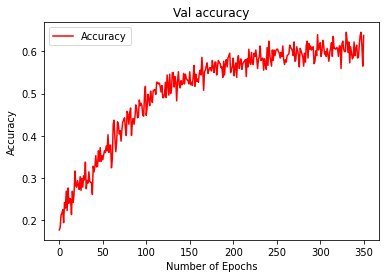

In [85]:
# # Plot the accuracy curve for validation set
# import matplotlib.pyplot as plt
# plt.plot(historyVal.history['val_accuracy'], color='r', label="Accuracy")

# plt.title("Val accuracy")
# plt.xlabel("Number of Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

In [86]:
# predict = model.predict(X_test)[0]
# predict = [np.argmax(pre) for pre in predict]
# print(predict)
# y_test.head()